In [1]:
from xgboost import XGBClassifier
import warnings
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from tabpfn_new.scripts.transformer_prediction_interface import TabPFNClassifier, MedPFNClassifier
from tabpfn_new.scripts.model_builder import load_model
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
from evaluate import *
from load_models import *
import matplotlib.pyplot as plt
import torch
import openml
import time
pd.set_option('display.expand_frame_repr', False)

In [2]:
path = "datasets/data_all.csv"
all_data, labels = get_microbiome(path)
all_data = remove_zero_features(all_data)
all_data, labels = unison_shuffled_copies(all_data, labels, seed=42)

In [4]:
save = False
sampling = None
cv = 5
best_delete = 0
strat_split = True
n_optim = 1000
cat_optim = 10
ft_epochs = 10
ft_lr = 1e-7
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = None#"permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight"
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
models = [
    #CatBoostOptim(n_optim=cat_optim),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    #RandomForestClassifier(),
    XGBoostOptim(n_optim=n_optim),
    #LogisticRegression(max_iter=1000), 
    #TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
]

for reducer in [AnovaSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
#reducer = None
#for reduce_data in [top_anova, top_non_zero, top_mean, top_std, top_max, pca_reduce]:
    #data = reduce_data(all_data, labels, 100)
    #print(all_data.shape)
    #for dele in range(1,100):
    #reducer.k = 100
    #reducer = None
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
            model, all_data, labels, metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete)

    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    red_name = reducer.__class__.__name__
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/baseline_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}'
    print("\n", "\n", red_name, "\n", results_full.round(3))
    #results_full.to_csv(save_path)


 
 AnovaSelect 
                accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
XGBClassifier          0.944         0.009           0.547          0.105        0.293       0.131         0.639        0.062    0.364   0.131         0.019        0.002
XGBoostOptim           0.934         0.020           0.444          0.224        0.320       0.160         0.646        0.085    0.366   0.175       111.005       16.638


[W 2024-10-17 22:20:34,348] Trial 457 failed with parameters: {'lambda': 1.8301596352423582e-14, 'alpha': 1.5255810970734498e-13, 'subsample': 0.9622570701706807, 'colsample_bytree': 0.5648996216407549, 'colsample_bylevel': 0.6962167547266416, 'max_depth': 10, 'min_child_weight': 6.403857134627819e-16, 'eta': 0.8469610861314875, 'gamma': 3.346196884109071e-16} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\lenna\anaconda3\envs\master4\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\lenna\Desktop\MT\TabPFN-medical\load_models.py", line 170, in objective
    model.fit(X_train, y_train)
  File "C:\Users\lenna\anaconda3\envs\master4\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\lenna\anaconda3\envs\master4\Lib\site-packages\xgboost\sklearn.py", line

In [15]:
path = "datasets/data_all.csv"
all_data, labels = get_microbiome(path)
all_data = remove_zero_features(all_data)

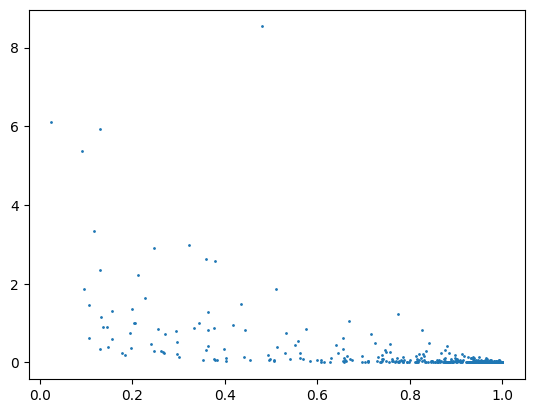

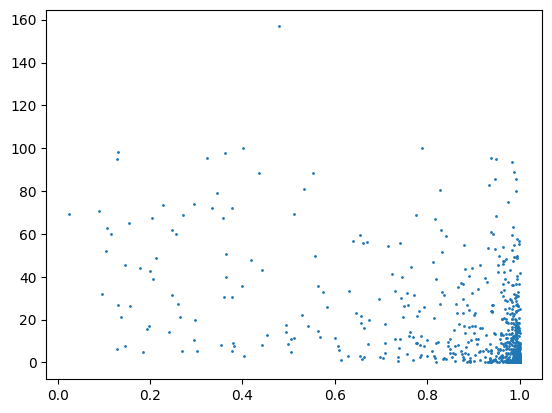

In [27]:
counts = np.count_nonzero(all_data, axis=0)
counts = 1-counts/all_data.shape[0]
means = np.mean(all_data, axis=0)
plt.scatter(counts, means, s=1)
plt.show()
plt.scatter(counts, np.max(all_data, axis=0), s=1)

In [26]:
print(error)

NameError: name 'error' is not defined

In [ ]:
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline"
run_name = "medium_net_mlp_balance_bsplit_baseline_longer"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
for sampling in [None]:#, undersample]:
    cv = 5
    strat_split = True
    n_optim = 1000
    cat_optim = 10
    ft_epochs = 10
    ft_lr = 1e-8
    max_s = 1024
    max_q = 128
    max_samples = None
    no_pre_process = False
    multi_decoder = None
    N_ens = 5
    metrics = ["accuracy", "precision", "recall", "roc_auc"]
    models = [
        #CatBoostOptim(n_optim=cat_optim),
        #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder, ft_epochs=ft_epochs, ft_lr=ft_lr,
        #                 max_s=max_s, max_q=max_q, no_preprocess_mode=no_pre_process),
        MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
        #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=5, no_preprocess_mode=True),
        XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
        XGBoostOptim(n_optim=n_optim),
        LogisticRegression(max_iter=500), 
        TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
        TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
    ]
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(model, data, labels, metrics, strat_split, cv, sampling, max_samples)
    #results_sorted = results.sort_values("roc_auc")
    #print(results_sorted)
    print(results_mean)
    print(results_std)

In [ ]:
cols = []
for m in metrics + "runtime":
    cols.append(m)
    cols.append(m+" std")

In [ ]:

dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
#model, config = load_model(path, filename, device="cpu", eval_positions=None, verbose=0)
#pred_model = TabPFNClassifier(model[2], config, device="cpu", N_ensemble_configurations=5, no_preprocess_mode=False)
for sampling in [None]:
    cv = 3
    strat_split = True
    n_optim = 10
    ft_epochs = 10
    max_samples = None
    metrics = metrics = ["accuracy", "precision", "recall", "roc_auc"]
    models = [
        RandomForestClassifier()
        #CatBoostOptim(n_optim=n_optim),
        #pred_model,
        #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=3, no_preprocess_mode=True),
        #XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
        #XGBoostOptim(n_optim=n_optim),
        #LogisticRegression(max_iter=500), 
        #TabPFNClassifier(device='cpu', N_ensemble_configurations=3, no_preprocess_mode=True),
        #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
    ]
    results = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                           index=[m.__class__.__name__ for m in models],
                          columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results.iloc[ii,:] = cross_validate_sample(model, data, labels, metrics, strat_split, cv, sampling, max_samples)
    results_sorted = results.sort_values("roc_auc")
    
    print(results_sorted)

In [ ]:
print(results_sorted)